## Vacuum Neutrino Oscillations

Here is a notebook for homogeneous gas model.

Here we are talking about a homogeneous gas bulk of neutrinos with single energy. The EoM is
$$
i \partial_t \rho_E = \left[ \frac{\delta m^2}{2E}B ,\rho_E \right]
$$

while the EoM for antineutrinos is
$$
i \partial_t \bar\rho_E = \left[- \frac{\delta m^2}{2E}B ,\bar\rho_E \right]
$$

Initial:
Homogeneous, Isotropic, Monoenergetic $\nu_e$ and $\bar\nu_e$

The equations becomes
$$
i \partial_t \rho_E = \left[ \frac{\delta m^2}{2E} B  ,\rho_E \right]
$$
$$
i \partial_t \bar\rho_E = \left[- \frac{\delta m^2}{2E}B,\bar\rho_E \right]
$$



Define $\omega=\frac{\delta m^2}{2E}$,  $\omega = \frac{\delta m^2}{-2E}$, $\mu=\sqrt{2}G_F n_\nu$
$$
i \partial_t \rho_E = \left[ \omega B ,\rho_E \right]
$$
$$
i \partial_t \bar\rho_E = \left[\bar\omega B,\bar\rho_E \right]
$$


where

$$
B = \frac{1}{2} \begin{pmatrix} 
-\cos 2\theta_v & \sin 2\theta_v \\
\sin 2\theta_v & \cos 2\theta_v
\end{pmatrix} = 
\begin{pmatrix} 
-0.38729833462 & 0.31622776601\\
0.31622776601 & 0.38729833462
\end{pmatrix}
$$

$$
L = \begin{pmatrix}
1 & 0 \\
0 & 0
\end{pmatrix}
$$

Initial condition 
$$
\rho(t=0) = \begin{pmatrix}
1 & 0 \\
0 & 0
\end{pmatrix}
$$

$$
\bar\rho(t=0) =\begin{pmatrix}
1 & 0 \\
0 & 0
\end{pmatrix}
$$

define the following quantities

1. hbar$=\hbar$
%2. delm2E$= \delta m^2/2E$
%3. lamb $= \lambda$, lambb $= \bar\lambda$
%4. gF $= G_F$
%5. mu $=\mu$
6. omega $=\omega$, omegab $=-\bar\omega$

## Numerical

In [162]:
# This line configures matplotlib to show figures embedded in the notebook, 
# instead of opening a new window for each figure. More about that later. 
# If you are using an old version of IPython, try using '%pylab inline' instead.
%matplotlib inline
%load_ext snakeviz

import numpy as np
from scipy.optimize import minimize
from scipy.special import expit
import matplotlib.pyplot as plt

from matplotlib.lines import Line2D

import timeit

import pandas as pd

import plotly.plotly as py
from plotly.graph_objs import *
import plotly.tools as tls

The snakeviz extension is already loaded. To reload it, use:
  %reload_ext snakeviz


In [163]:
# hbar=1.054571726*10**(-34)
hbar=1.0
delm2E=1.0
# lamb=1.0  ## lambda for neutrinos
# lambb=1.0 ## lambda for anti neutrinos
# gF=1.0
# nd=1.0  ## number density
# ndb=1.0   ## number density
omega=1.0
omegab=-1.0

## Here are some matrices to be used

elM = np.array([[1.0,0.0],[0.0,0.0]])
bM = 1.0/2*np.array( [ [ - 0.38729833462,0.31622776601] , [0.31622776601,0.38729833462] ] )

## sqareroot of 2
sqrt2=np.sqrt(2.0)

~~Using Mathematica, I can find the 4\*2 equations~~

In [164]:

#r11prime(t)

## The matrix eqn for neutrinos. Symplify the equation to the form A.X=0. Here I am only writing down the LHS.
## Eqn for r11'
# 1/2*( r21(t)*( bM12*delm2E - 2*sqrt2*gF*rb12(t) ) + r12(t) * ( -bM21*delm2E + 2*sqrt2*gF*rb21(t) ) - 1j*r11prime(t)  )
## Eqn for r12'
# 1/2*( r22(t)* ( bM12 ) )

### wait a minute I don't actually need to write down this. I can just do this part in numpy.

I am going to substitute all density matrix elements using their corrosponding network expressions.

So first of all, I need the network expression for the unknown functions.

A function is written as

$$ y_i= 1+t_i v_k f(t_i w_k+u_k) ,$$

while it's derivative is

$$v_k f(t w_k+u_k) + t v_k f(tw_k+u_k) (1-f(tw_k+u_k)) w_k .$$

Now I can write down the equations using these two forms.

In [165]:
def trigf(x):
    #return 1/(1+np.exp(-x)) # It's not bad to define this function here for people could use other functions other than expit(x).
    return expit(x)

In [166]:
## The time derivative part

### Here are the initial conditions

init = np.array( [[1,0],[0,0]] )


### For neutrinos

def rho(x,ti,initialCondition): # x is the input structure arrays, ti is a time point

    v11,w11,u11,v12,w12,u12,v21,w21,u21,v22,w22,u22 = x[:12]
        
    elem11= np.sum(ti * v11 * trigf( ti*w11 +u11 ) )
    elem12= np.sum(ti * v12 * trigf( ti*w12 +u12 ) )
    elem21= np.sum(ti * v21 * trigf( ti*w21 +u21 ) )
    elem22= np.sum(ti * v22 * trigf( ti*w22 +u22 ) )
    
    return initialCondition + np.array([[ elem11 , elem12 ],[elem21, elem22]])


In [167]:
## Test
xtemp=np.ones(120)
rho(xtemp,0,init)

array([[ 1.,  0.],
       [ 0.,  0.]])

In [168]:
## Define Hamiltonians for both

def hamilv():
    return delm2E*bM

In [169]:
## The commutator

def commv(x,ti,initialCondition):
    
    return np.dot(hamilv(), rho(x,ti,initialCondition) ) - np.dot(rho(x,ti,initialCondition), hamilv() )


In [170]:
## Test

print bM

print hamilv()

print "neutrino\n",commv(xtemp,0,init)

[[-0.19364917  0.15811388]
 [ 0.15811388  0.19364917]]
[[-0.19364917  0.15811388]
 [ 0.15811388  0.19364917]]
neutrino
[[ 0.         -0.15811388]
 [ 0.15811388  0.        ]]


In [272]:
## The COST of the eqn set

regularization = 0.0001

def costvTi(x,ti,initialCondition): # l is total length of x
    
    v11,w11,u11,v12,w12,u12,v21,w21,u21,v22,w22,u22 = x[:12]

    fvec11 = np.array(trigf(ti*w11 + u11) )  # This is a vector!!!
    fvec12 = np.array(trigf(ti*w12 + u12) )
    fvec21 = np.array(trigf(ti*w21 + u21) )
    fvec22 = np.array(trigf(ti*w22 + u22) )
    
    costi11= ( np.sum (v11*fvec11 + ti * v11* fvec11 * ( 1 -  fvec11  ) * w11 ) + 1.0j*  ( commv(x,ti,initialCondition)[0,0] )  )  
    costi12= ( np.sum (v12*fvec12 + ti * v12* fvec12 * ( 1 -  fvec12  ) * w12 ) + 1.0j*  ( commv(x,ti,initialCondition)[0,1] )  )  
    costi21= ( np.sum (v21*fvec21 + ti * v21* fvec21 * ( 1 -  fvec21  ) * w21 ) + 1.0j*  ( commv(x,ti,initialCondition)[1,0] )  )  
    costi22= ( np.sum (v22*fvec22 + ti * v22* fvec22 * ( 1 -  fvec22  ) * w22 ) + 1.0j*  ( commv(x,ti,initialCondition)[1,1] )  )  

    
    #return (np.real(costi11))**2 + (np.real(costi12))**2+ (np.real(costi21))**2 +  (np.real(costi22))**2 + (np.imag(costi11))**2 + (np.imag(costi12))**2+ (np.imag(costi21))**2 +  (np.imag(costi22))**2
    
    #return np.abs(np.real(costi11)) + np.abs(np.real(costi12))+ np.abs(np.real(costi21)) +  np.abs(np.real(costi22)) + np.abs(np.imag(costi11)) + np.abs(np.imag(costi12))+ np.abs(np.imag(costi21)) +  np.abs(np.imag(costi22))

    return ( (np.real(costi11))**2 + (np.real(costi12))**2+ (np.real(costi21))**2 +  (np.real(costi22))**2 + (np.imag(costi11))**2 + (np.imag(costi12))**2+ (np.imag(costi21))**2 +  (np.imag(costi22))**2 )/v11.size + regularization * ( np.sum(v11**2)+np.sum(v12**2)+np.sum(v21**2) + np.sum(v22**2) + np.sum(w11**2) + np.sum(w12**2)+ np.sum(w21**2)+ np.sum(w22**2) )



In [273]:
costvTi(xtemp,2,init)

5.9571317039229577

In [274]:
## Calculate the total cost

def costv(x,t,initialCondition):

    t = np.array(t)
    
    costvTotal = np.sum( costvTList(x,t,initialCondition)  )
        
    return costvTotal
    

def costvTList(x,t,initialCondition):  ## This is the function WITHOUT the square!!! 
        
    t = np.array(t)
    
    costvList = np.asarray([])
    
    for temp in t:
        tempElement = costvTi(x,temp,initialCondition)
        costvList = np.append(costvList, tempElement)
        
    return np.array(costvList)

    

In [275]:
ttemp = np.linspace(0,10)
print ttemp

[  0.           0.20408163   0.40816327   0.6122449    0.81632653
   1.02040816   1.2244898    1.42857143   1.63265306   1.83673469
   2.04081633   2.24489796   2.44897959   2.65306122   2.85714286
   3.06122449   3.26530612   3.46938776   3.67346939   3.87755102
   4.08163265   4.28571429   4.48979592   4.69387755   4.89795918
   5.10204082   5.30612245   5.51020408   5.71428571   5.91836735
   6.12244898   6.32653061   6.53061224   6.73469388   6.93877551
   7.14285714   7.34693878   7.55102041   7.75510204   7.95918367
   8.16326531   8.36734694   8.57142857   8.7755102    8.97959184
   9.18367347   9.3877551    9.59183673   9.79591837  10.        ]


In [276]:
ttemp = np.linspace(0,10)
print costvTList(xtemp,ttemp,init)
print costv(xtemp,ttemp,init)

[  2.18858658   2.69181119   3.17657819   3.62928532   4.04433065
   4.4227527    4.77017906   5.09476415   5.40551177   5.7111183
   6.01930406   6.33652211   6.66791949   7.01744398   7.38801874
   7.78173467   8.20003235   8.64386006   9.11380383   9.61019022
  10.1331652   10.6827532   11.25890034  11.86150545  12.49044177
  13.14557185  13.82675734  14.53386531  15.26677189  16.02536424
  16.80954131  17.61921376  18.45430348  19.3147428   20.20047349
  21.11144577  22.04761735  23.00895246  23.99542098  25.00699765
  26.04366137  27.10539457  28.19218266  29.30401359  30.44087738
  31.60276587  32.78967231  34.00159123  35.23851811  36.50044933]
765.926679446


## Minimization

Here is the minimization

In [342]:
tlin = np.linspace(0,15,160)
# tlinTest = np.linspace(0,14,10) + 0.5
# initGuess = np.ones(120)
initGuess = np.asarray(np.split(np.random.rand(1,720)[0],12))
    


costvF = lambda x: costv(x,tlin,init)
costvFTest = lambda x: costv(x,tlinTest,init)

In [343]:
print costv(initGuess,tlin,init)#, costv(initGuess,tlinTest,init)

54012.7417059 3411.88424057


In [344]:
## %%snakeviz
# startCG = timeit.default_timer()
#costFResultCG = minimize(costF,initGuess,method="CG")
#stopCG = timeit.default_timer()

#print stopCG - startCG

#print costFResultCG

In [347]:
#%%snakeviz
#startBFGS = timeit.default_timer()
#costvFResultBFGS = minimize(costvF,initGuess,method="BFGS")
#stopBFGS = timeit.default_timer()

#print stopBFGS - startBFGS

#print costvFResultBFGS

In [348]:
%%snakeviz
startSLSQP = timeit.default_timer()
costvFResultSLSQP = minimize(costvF,initGuess,method="SLSQP")
stopSLSQP = timeit.default_timer()

print stopSLSQP - startSLSQP

print costvFResultSLSQP

47288.168766
  status: 9
 success: False
    njev: 101
    nfev: 72964
     fun: 1.4173343391905522
       x: array([ -4.46374592e-01,  -1.66866794e-01,  -1.25744630e+00,
        -2.18047108e-02,  -5.41072027e-02,   2.42277599e+01,
        -1.27154890e-01,  -9.70499008e-02,  -5.03999403e-01,
         5.78028700e-01,  -1.62505417e-01,  -1.55494869e+00,
         2.66375584e-01,   6.04961964e-01,   2.77702799e-01,
         9.89926034e-01,   4.87373501e-02,   2.01055515e-01,
         4.02080498e-01,   3.73839391e-01,   8.34112501e-01,
         7.65863109e-01,   6.00275396e-01,   1.13525960e-01,
         4.51215980e-01,   7.86420783e-01,   5.45441437e-01,
         8.76282955e-01,   7.89382563e-02,   9.20721662e-01,
         6.73220025e-01,   1.63729947e-01,   8.26821274e-01,
         2.43112429e-01,   7.40421649e-01,   3.31242864e-01,
         5.90521630e-01,   2.84727629e-01,   8.88808431e-01,
         2.70237617e-01,   9.88981429e-01,   8.20392521e-01,
         1.96389767e-01,   6.5132394

In [349]:
#%%snakeviz
#startSLSQPTest = timeit.default_timer()
#costvFResultSLSQPTest = minimize(costvFTest,initGuess,method="SLSQP")
#stopSLSQPTest = timeit.default_timer()

#print stopSLSQPTest - startSLSQPTest

#print costvFResultSLSQPTest

In [350]:
costvFResultSLSQP.get('x')

array([ -4.46374592e-01,  -1.66866794e-01,  -1.25744630e+00,
        -2.18047108e-02,  -5.41072027e-02,   2.42277599e+01,
        -1.27154890e-01,  -9.70499008e-02,  -5.03999403e-01,
         5.78028700e-01,  -1.62505417e-01,  -1.55494869e+00,
         2.66375584e-01,   6.04961964e-01,   2.77702799e-01,
         9.89926034e-01,   4.87373501e-02,   2.01055515e-01,
         4.02080498e-01,   3.73839391e-01,   8.34112501e-01,
         7.65863109e-01,   6.00275396e-01,   1.13525960e-01,
         4.51215980e-01,   7.86420783e-01,   5.45441437e-01,
         8.76282955e-01,   7.89382563e-02,   9.20721662e-01,
         6.73220025e-01,   1.63729947e-01,   8.26821274e-01,
         2.43112429e-01,   7.40421649e-01,   3.31242864e-01,
         5.90521630e-01,   2.84727629e-01,   8.88808431e-01,
         2.70237617e-01,   9.88981429e-01,   8.20392521e-01,
         1.96389767e-01,   6.51323945e-01,   9.65113150e-01,
         9.56699834e-01,   6.49157385e-02,   8.43218339e-01,
         6.58998887e-01,

In [351]:
#np.savetxt('./assets/homogen/optimize_ResultSLSQPT2120_Vac.txt', costvFResultSLSQP.get('x'), delimiter = ',')

## Functions

Find the solutions to each elements.

In [352]:
# costvFResultSLSQPx = np.genfromtxt('./assets/homogen/optimize_ResultSLSQP.txt', delimiter = ',')

In [353]:
## The first element of neutrino density matrix
xresult = np.asarray(costvFResultSLSQP.get('x'))
#xresult = np.asarray(costvFResultBFGS.get('x'))

print xresult

plttlin=np.linspace(0,15,100)

pltdata11 = np.array([])
pltdata11Test = np.array([])
pltdata22 = np.array([])

for i in plttlin:
    pltdata11 = np.append(pltdata11 ,rho(xresult,i,init)[0,0] )
    
print pltdata11

#for i in plttlin:
#    pltdata11Test = np.append(pltdata11Test ,rho(xresultTest,i,init)[0,0] )
#    
#print pltdata11Test


for i in plttlin:
    pltdata22 = np.append(pltdata22 ,rho(xresult,i,init)[1,1] )
    
print pltdata22

print rho(xresult,0,init)

[ -4.46374592e-01  -1.66866794e-01  -1.25744630e+00  -2.18047108e-02
  -5.41072027e-02   2.42277599e+01  -1.27154890e-01  -9.70499008e-02
  -5.03999403e-01   5.78028700e-01  -1.62505417e-01  -1.55494869e+00
   2.66375584e-01   6.04961964e-01   2.77702799e-01   9.89926034e-01
   4.87373501e-02   2.01055515e-01   4.02080498e-01   3.73839391e-01
   8.34112501e-01   7.65863109e-01   6.00275396e-01   1.13525960e-01
   4.51215980e-01   7.86420783e-01   5.45441437e-01   8.76282955e-01
   7.89382563e-02   9.20721662e-01   6.73220025e-01   1.63729947e-01
   8.26821274e-01   2.43112429e-01   7.40421649e-01   3.31242864e-01
   5.90521630e-01   2.84727629e-01   8.88808431e-01   2.70237617e-01
   9.88981429e-01   8.20392521e-01   1.96389767e-01   6.51323945e-01
   9.65113150e-01   9.56699834e-01   6.49157385e-02   8.43218339e-01
   6.58998887e-01   8.99004470e-01   7.87380611e-01   5.21213458e-01
   2.46361642e-01   5.13852392e-01   3.11033707e-01   8.33818356e-01
   8.60054641e-01   7.73073479e-01

In [354]:
rho(xresult,6.6,init)

array([[ 0.74554352, -0.14391109],
       [-0.20266366,  0.25709358]])

In [355]:
#np.savetxt('./assets/homogen/optimize_pltdatar11.txt', pltdata11, delimiter = ',')
#np.savetxt('./assets/homogen/optimize_pltdatar22.txt', pltdata22, delimiter = ',')

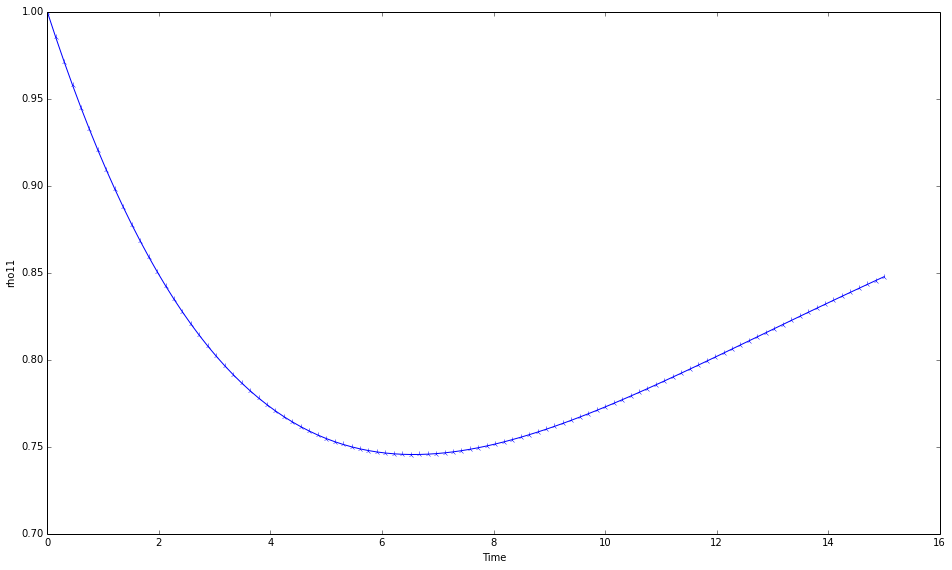

In [356]:
plt.figure(figsize=(16,9.36))
plt.ylabel('rho11')
plt.xlabel('Time')
plt11=plt.plot(plttlin,pltdata11,"b4-",label="vac_rho11")
#plt.plot(plttlin,pltdata11Test,"m4-",label="vac_rho11Test")
plt.show()
#py.iplot_mpl(plt.gcf(),filename="vac_HG-rho11")


# tls.embed("https://plot.ly/~emptymalei/73/")

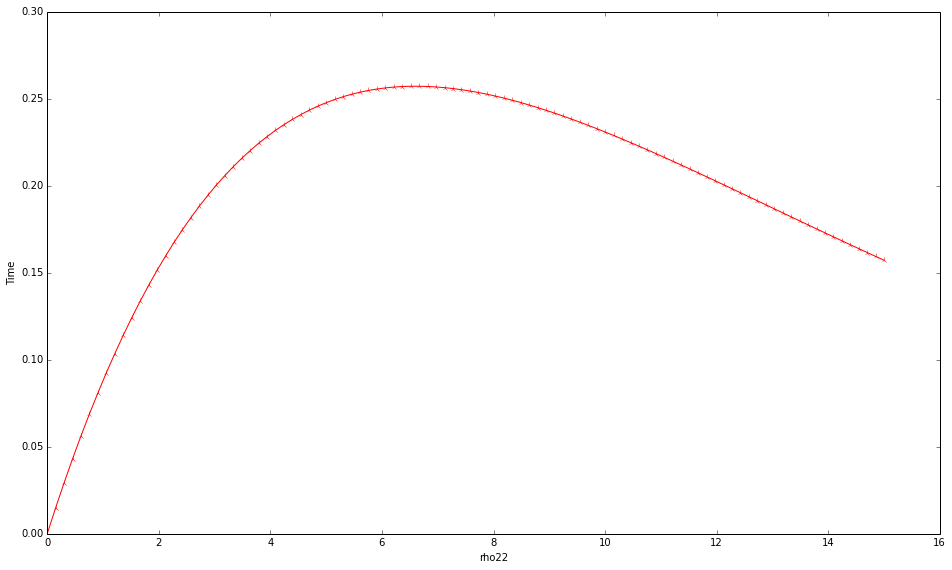

In [357]:
plt.figure(figsize=(16,9.36))
plt.ylabel('Time')
plt.xlabel('rho22')
plt22=plt.plot(plttlin,pltdata22,"r4-",label="vac_rho22")
plt.show()
#py.iplot_mpl(plt.gcf(),filename="vac_HG-rho22")

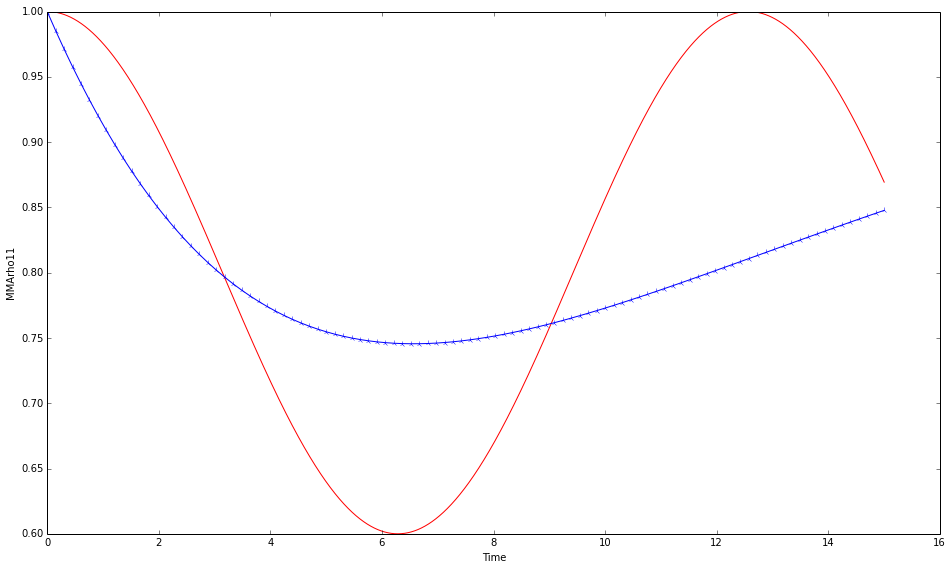

In [358]:
MMA_optmize_Vac_pltdata = np.genfromtxt('./assets/homogen/MMA_optmize_Vac_pltdata.txt', delimiter = ',')

plt.figure(figsize=(16,9.36))
plt.ylabel('MMArho11')
plt.xlabel('Time')
plt.plot(np.linspace(0,15,4501),MMA_optmize_Vac_pltdata,"r-",label="MMAVacrho11")
plt.plot(plttlin,pltdata11,"b4-",label="vac_rho11")
plt.show()
#py.iplot_mpl(plt.gcf(),filename="MMA-rho11-Vac-80-60")

## Practice

In [341]:
xtemp1 = np.arange(4)
xtemp1.shape = (2,2)
print xtemp1
xtemp1[0,1]
np.dot(xtemp1,xtemp1)
xtemp1[0,1]

[[0 1]
 [2 3]]


1